In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import glob
from IPython.display import display
from IPython.core.debugger import set_trace
from collections import OrderedDict
import itertools
import os
import sys
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
import scipy
import sympy
import pandas as pd

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

import cufflinks

import qutip
import theano
import theano.tensor as T

src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

import qubit_network.net_analysis_tools as nat
import qubit_network.utils
from qubit_network.utils import chop, complex2bigreal, bigreal2complex, bigreal2qobj
from qubit_network.QubitNetwork import pauli_product
from qubit_network.model import QubitNetworkGateModel
from qubit_network.Optimizer import Optimizer
from qubit_network.net_analysis_tools import NetDataFile, NetsDataFolder

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Training Toffoli from reduced expression

Use the following expression as model:
$$
\tilde{\mathcal H}_{\operatorname{Toff}} =
	J_{000} + J_{300} Z_1 + J_{030} Z_2 + J_{001} X_3 +
	Z_3 [J_{303}(1 + Z_1) + J_{033} (1 + Z_2) ] +
	(J_{101} X_1 + J_{011} X_2) (1 + X_3) +
	J_{220} (X_1 X_2 + Y_1 Y_2) + J_{330} Z_1 Z_2.
$$

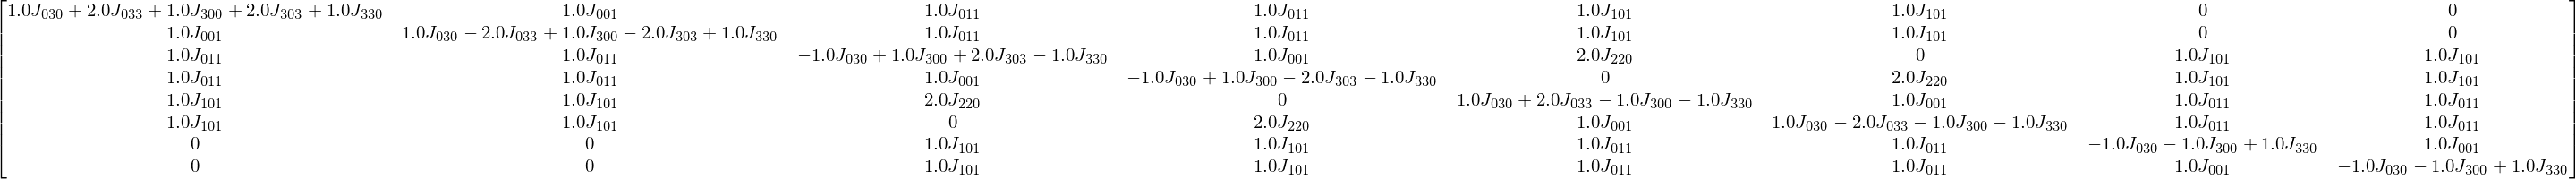

In [3]:
sympy.init_printing()
def J(*args):
    return sympy.Symbol('J' + ''.join(str(arg) for arg in args))
def pauli(*args):
    return pauli_product(*args)
toffoli_diagonal = J(3, 0, 0) * pauli(3, 0, 0)
toffoli_diagonal += J(0, 3, 0) * pauli(0, 3, 0)
toffoli_diagonal += J(0, 0, 1) * pauli(0, 0, 1)
toffoli_diagonal += J(3, 0, 3) * (pauli(0, 0, 3) + pauli(3, 0, 3))
toffoli_diagonal += J(0, 3, 3) * (pauli(0, 0, 3) + pauli(0, 3, 3))
toffoli_diagonal += (J(1, 0, 1) * pauli(1, 0, 0) + J(0, 1, 1) * pauli(0, 1, 0)) * (pauli(0, 0, 0) + pauli(0, 0, 1))
toffoli_diagonal += J(2, 2, 0) * (pauli(1, 1, 0) + pauli(2, 2, 0))
toffoli_diagonal += J(3, 3, 0) * pauli(3, 3, 0)
toffoli_diagonal

Compiling model ... done.


<IPython.core.display.Javascript object>


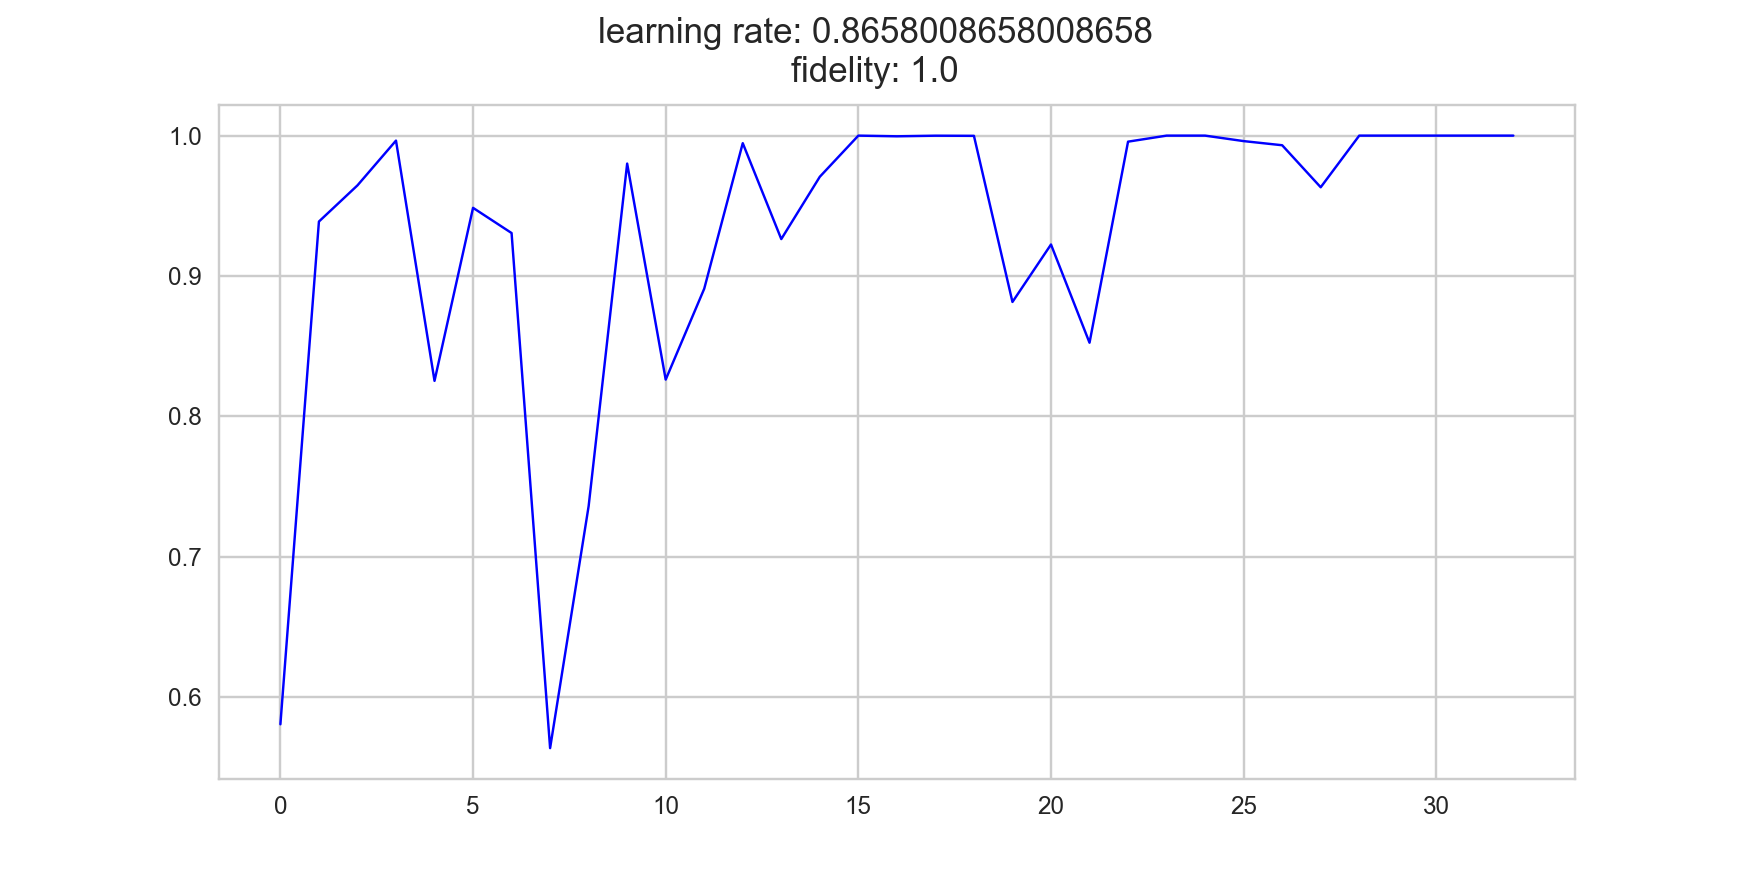

Fidelity 1 obtained, stopping.


In [7]:
net = QubitNetworkGateModel(sympy_expr=toffoli_diagonal, initial_values=4)
optimizer = Optimizer(
    net=net,
    learning_rate=1.,
    decay_rate=.005,
    n_epochs=500,
    batch_size=2,
    target_gate=qutip.toffoli(),
    training_dataset_size=200,
    test_dataset_size=100,
    sgd_method='momentum'
)
optimizer.run()

In [150]:
optimizer.save_results('../data/new_nets/toffoli_diagonal8.pickle')

Successfully saved to ../data/new_nets/toffoli_diagonal8.pickle


Take all nets saved as `../data/new_nets/toffoli_diagonal*.pickle`, extract their parameters training history and resave it into `data/parameters_histories`

In [87]:
import glob

toffoli_diagonal_nets = glob.glob('../data/new_nets/toffoli_diagonal*.pickle')
for file in toffoli_diagonal_nets:
    basename_noext = os.path.splitext(os.path.basename(file))[0]
    fig = Optimizer.load(file).plot_parameters_history(return_fig=True)
    fig.layout.title = 'Training history for Toffoli, using topology given by 3 conditions.<br>Final fidelity=1'
    plotly.offline.plot(fig, filename='../data/parameters_histories/' + basename_noext + '.html')
print('Done')

Done


## See the final interactions obtained for all the trained nets:

In [90]:
ndf = NetsDataFolder('../data/new_nets/')
ndf.plot_parameters(hlines=[])

# Static plots for paper

## Solutions for Toffoli diagonal

<IPython.core.display.Javascript object>


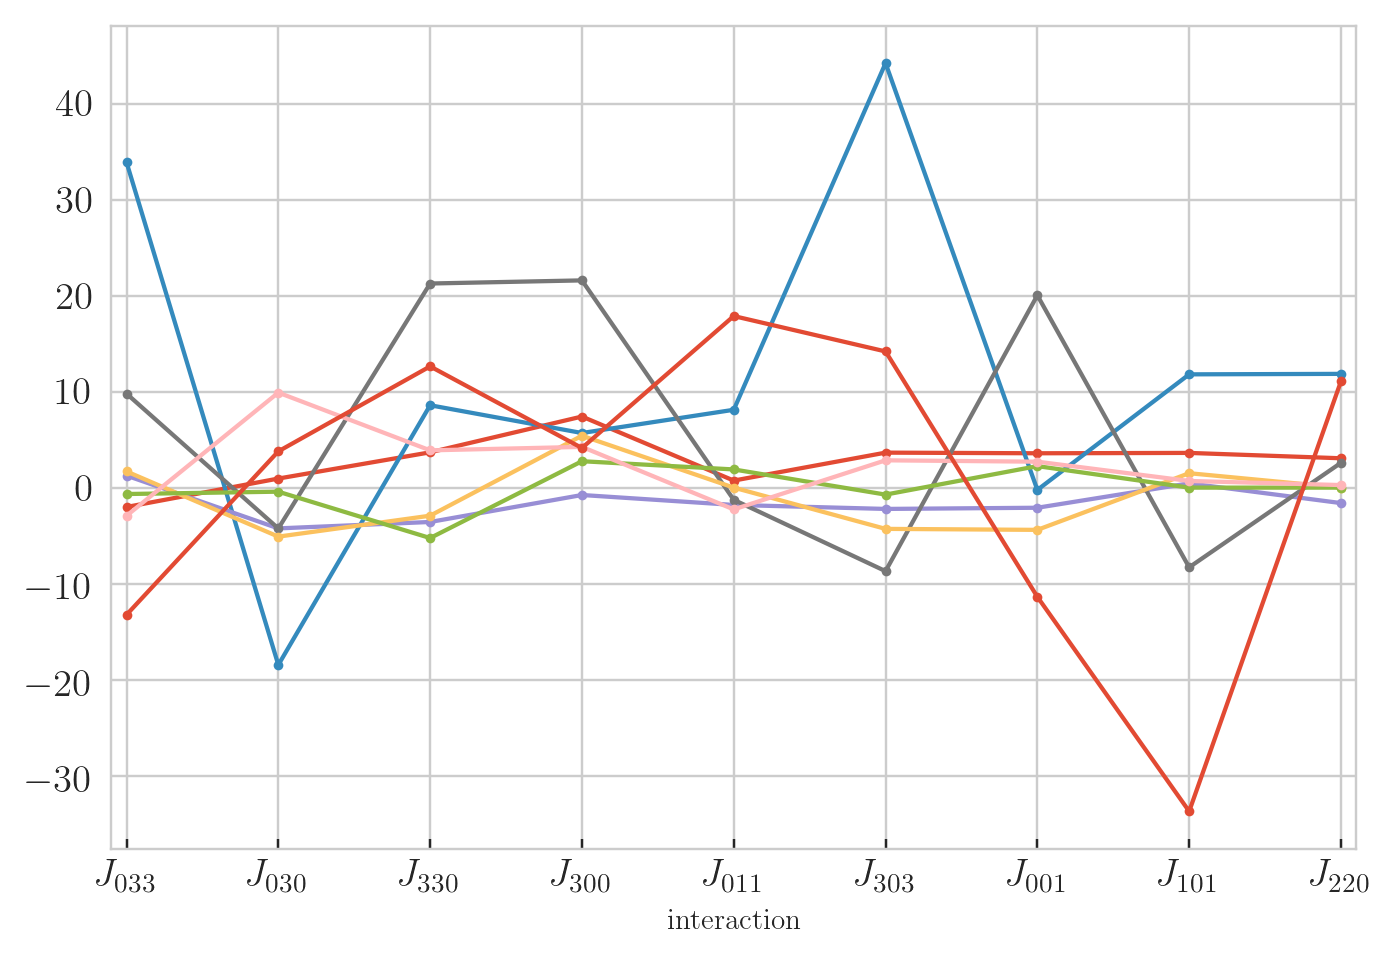

In [94]:
plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fig, ax = plt.subplots(1, 1)

ndf = NetsDataFolder('../data/new_nets/')
df = ndf.view_parameters().sort_index(axis=1)
df.plot(ax=ax, marker='o', markersize=4., legend=False)
# ax.set_title('Different solutions for Toffoli with diagonal interactions', fontsize=16)
# ax.set_xlabel('Parameters', fontsize=14)
# ax.set_ylabel('Values', fontsize=14)
# change font size of tick labels
ax.tick_params(axis='both', labelsize=16)
ax.tick_params(axis='x', length=4, direction='in')
# better range
ax.set_xlim(-0.1 , 8.1)
# mathify xaxis labels
ax.set_xticks(range(9))
xlabels = [label.get_text() for label in ax.get_xticklabels()]
def adjust_xlabel(text):
    return '$' + text[0] + '_{' + text[1:] + '}$'
ax.set_xticklabels([adjust_xlabel(label) for label in xlabels])
# fix sizes
plt.tight_layout()
# save to file
fig.savefig('toffoli_diagonal_solutions.pdf', bbox_inches='tight')

## Parameters histories

toffoli_diagonal


<IPython.core.display.Javascript object>


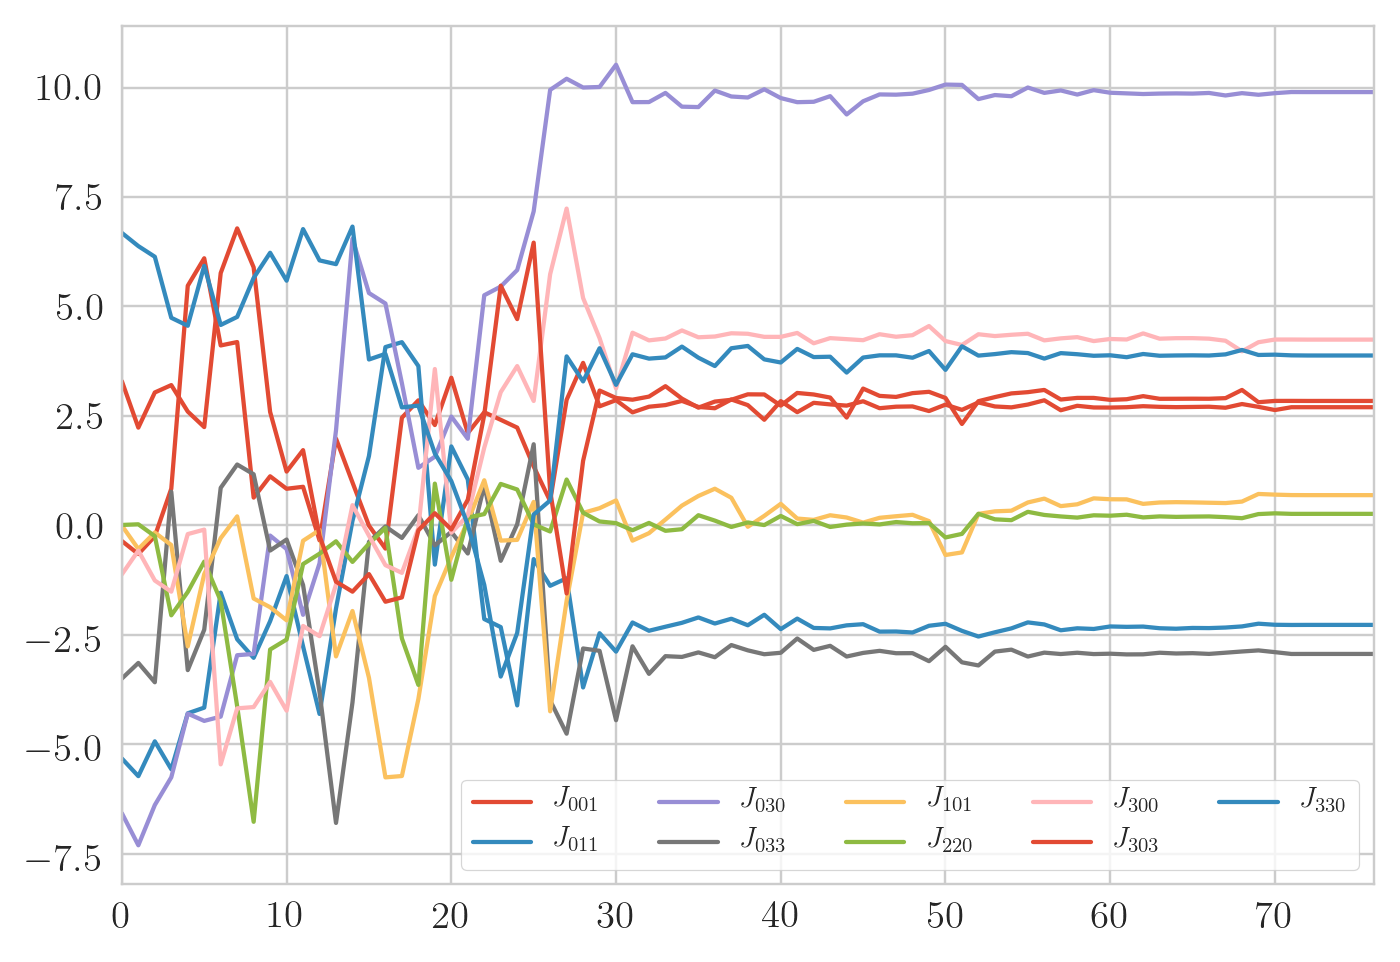

In [100]:
def _plot_parhistory(filename):
    # make output file name
    basename, ext = os.path.splitext(filename)
    basename = os.path.basename(basename)
    print(basename)
    out_filename = basename + '_parshistory.pdf'
    # set style
    plt.style.use('seaborn-whitegrid')
    # plt.style.use('ggplot')
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    opt = Optimizer.load(filename)
    df = opt.plot_parameters_history(return_df=True).sort_index(axis=1)
    # adjust style of columns names
    def adjust_label(text):
        return '$' + text[0] + '_{' + text[1:] + '}$'
    df.columns = df.columns.map(adjust_label)
    # make new figure
    fig, ax = plt.subplots(1, 1)
    # plot
    df.plot(ax=ax, legend=False)
    # bigger tick labels
    ax.tick_params(axis='both', labelsize=16)
    # make legend
    legend = ax.legend(loc='lower right', ncol=5, frameon=True, fancybox=True, fontsize='large')
    # legend.get_frame().set_facecolor('#00FFCC')
    # legend.get_frame().set_edgecolor('green')
    legend.get_frame().set_linewidth(0.5)
    # fix layout
    plt.tight_layout()
import glob
plt.ion()
_plot_parhistory('../data/new_nets/toffoli_diagonal.pickle')

In [95]:
def plot_parhistory(filename):
    # make output file name
    basename, ext = os.path.splitext(filename)
    basename = os.path.basename(basename)
    print(basename)
    out_filename = basename + '_parshistory.pdf'
    # set style
    plt.style.use('seaborn-whitegrid')
    # plt.style.use('ggplot')
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    opt = Optimizer.load(filename)
    df = opt.plot_parameters_history(return_df=True).sort_index(axis=1)
    # adjust style of columns names
    def adjust_label(text):
        return '$' + text[0] + '_{' + text[1:] + '}$'
    df.columns = df.columns.map(adjust_label)
    # make new figure
    fig, ax = plt.subplots(1, 1)
    # plot
    df.plot(ax=ax, legend=False)
    # bigger tick labels
    ax.tick_params(axis='both', labelsize=16)
    # make legend
    legend = ax.legend(loc='lower right', ncol=5, frameon=True, fancybox=True, fontsize='large')
    # legend.get_frame().set_facecolor('#00FFCC')
    # legend.get_frame().set_edgecolor('green')
    legend.get_frame().set_linewidth(0.5)
    # fix layout
    plt.tight_layout()
    # save to file
    fig.savefig(out_filename, bbox_inches='tight')
    # print('Saved {}'.format(out_filename))
import glob
plt.ioff()
# plot_parhistory('../data/new_nets/toffoli_diagonal.pickle')
for file in glob.glob('../data/new_nets/toffoli_diagonal*.pickle'):
    plot_parhistory(file)

toffoli_diagonal
toffoli_diagonal2
toffoli_diagonal3
toffoli_diagonal4
toffoli_diagonal5
toffoli_diagonal6
toffoli_diagonal7
toffoli_diagonal8


[None, None, None, None, None, None, None, None]

<IPython.core.display.Javascript object>


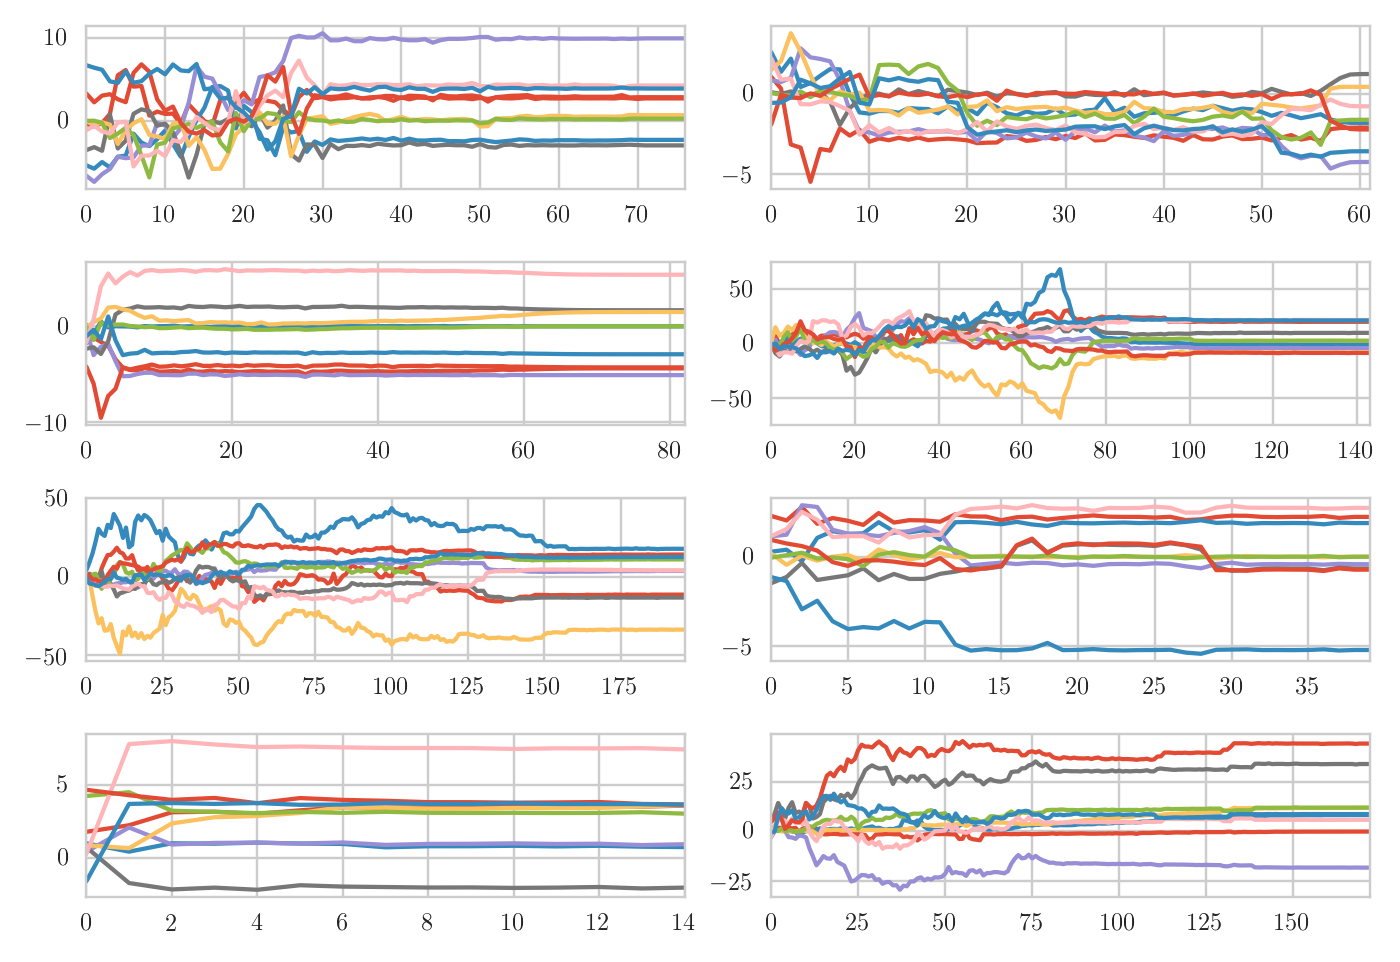

In [101]:
def _plot_pars_history(ax, filename):
    opt = Optimizer.load(filename)
    df = opt.plot_parameters_history(return_df=True).sort_index(axis=1)
    df.plot(ax=ax, legend=False)
    # bigger tick labels
    # ax.tick_params(axis='both', labelsize=16)
    # fix layout
    # plt.tight_layout()
    # save to file
    # fig.savefig(out_filename, bbox_inches='tight')

import glob
filenames = glob.glob('../data/new_nets/toffoli_diagonal*.pickle')
# set style
plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
# make new figure
fig, axs = plt.subplots(4, 2)
for ax, filename in zip(axs.flatten(), filenames):
    _plot_pars_history(ax, filename)
plt.tight_layout()